# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общий обзор имеющейся информации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('https://code.s3.yandex.net//datasets//real_estate_data.csv', sep='\t')
data.info()
display(data.head())

#rawdata = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


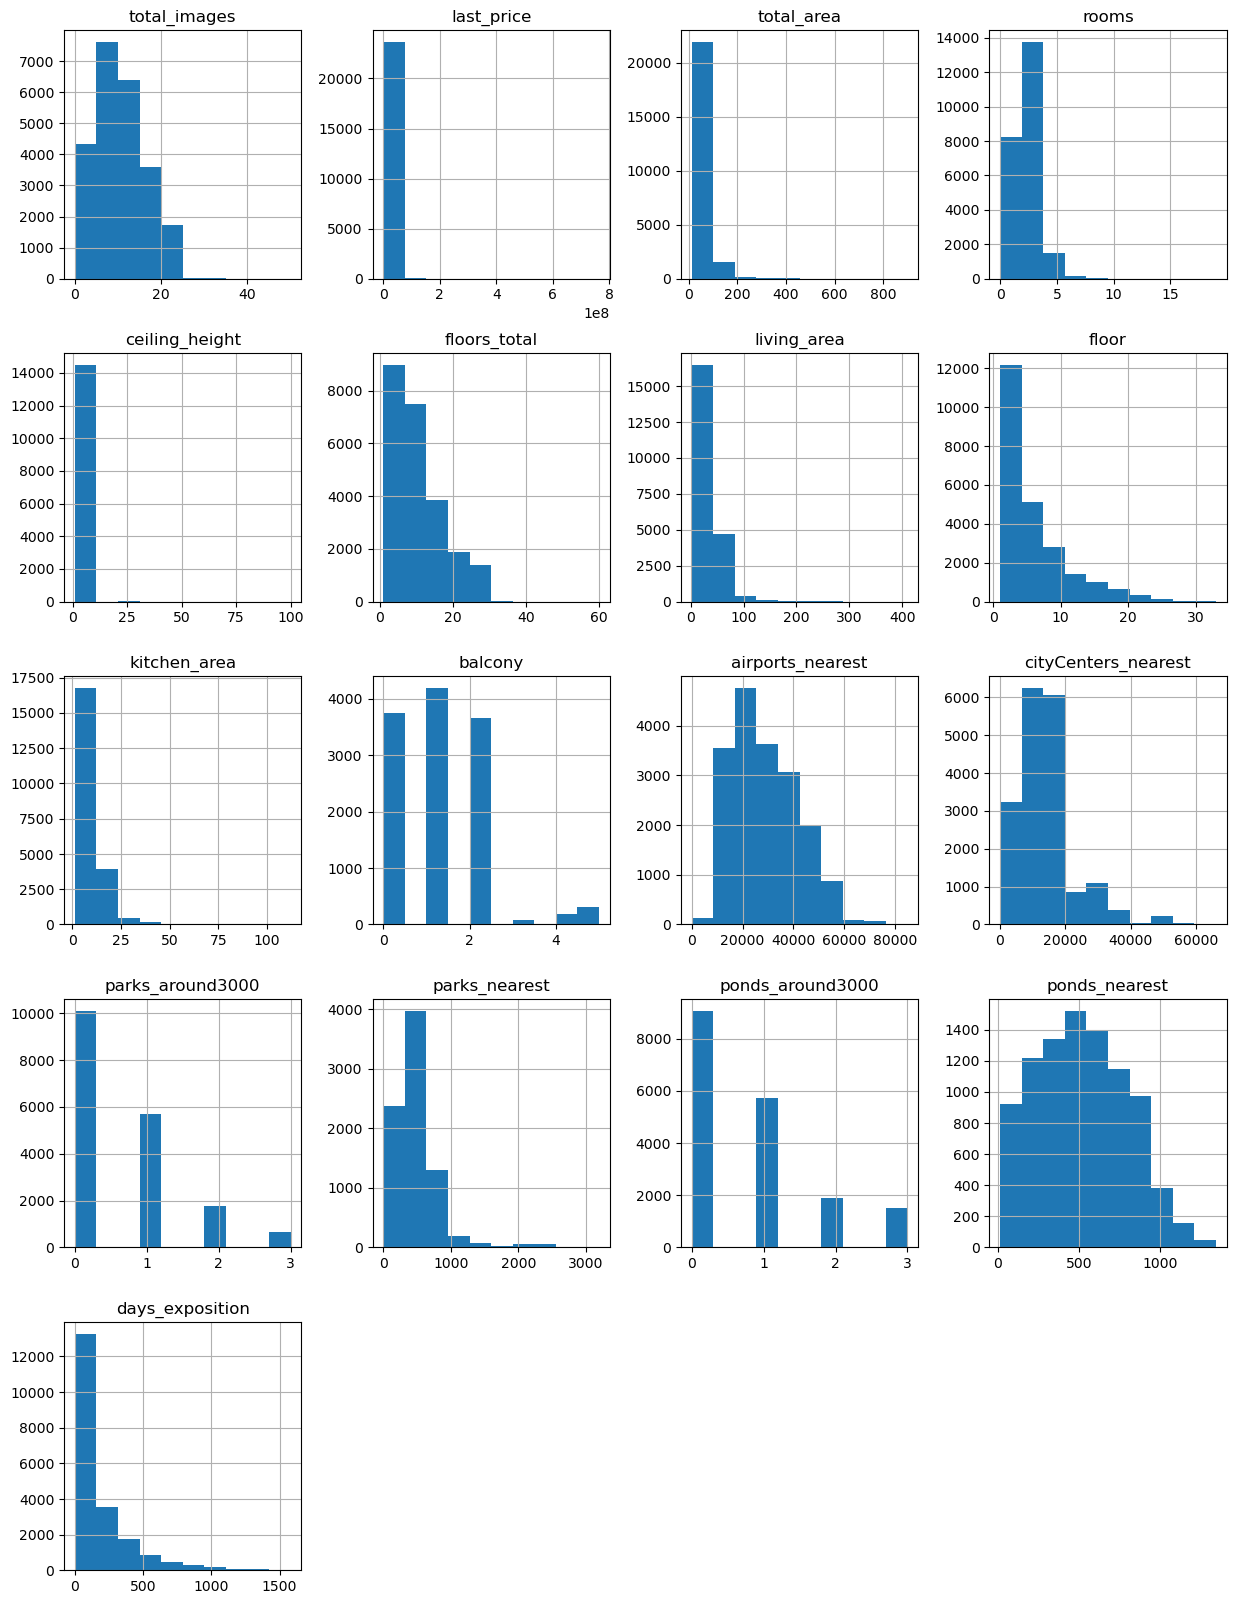

In [2]:
data.hist(figsize=(15,20))
plt.show()

### Предобработка данных

**2.1 Заполнение пропущенных значений в столбцах**

In [3]:
# в каких столбцах есть пропуски
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [4]:
data['ceiling_height'].value_counts().head(20)

2.50    3515
2.60    1646
2.70    1574
3.00    1112
2.80     993
2.55     980
2.75     910
2.65     676
3.20     277
3.10     203
2.90     164
3.30     141
2.56     139
3.50     130
2.57     103
2.85     101
3.40      92
2.54      83
2.64      81
2.52      79
Name: ceiling_height, dtype: int64

Вместо пропусков можно вставить:
- нули в колонки с количеством балконов, количеством ближайших парков и прудов 
- медианы в колонки с высотой потолков, общим количеством этажей и жилой площадью. Но сначала потолки удалить все, которые больше, чем 50 метров, а в диапазоне 20-40 метров значения поделить на десять - там явно пропущена запятая. Это все для того, чтобы с медианой случайно не промахнуться.
- медианное значение и в площадь кухни, но я б не стала*
- значение "неизвестно" в колонку с названием населенного пункта
- в колонку is_apartment - False, потому что квартиры принято по умолчанию считать не апартаментами, в противном случае это отдельно проговаривают
- ничего. Есть колонки, которые не очень принципиальны для анализа данных (удаленность от пруда, парка, аэропорта). Заполнять их медианным значением кажется некорректно, а выкидывать полностью эти строки - обеднять датасет. Поэтому тут пропуски оставим.

*Пропуски в площади кухни можно попытаться заполнить точнее. Об этом позже, в отдельном разделе. 

In [5]:
# заполнение пропусков

# нули в балконах, количестве прудов и парков в радиусе 3км
data[['balcony','parks_around3000', 'ponds_around3000']] = data[['balcony','parks_around3000', 'ponds_around3000']].fillna(0)

# разберемся с потолками, надо удалить все большее 50 и заменить данные в диапазоне более 10 метров на уменьшенные на порядок.  
data = data[data['ceiling_height']<50]
ceil = data['ceiling_height'] # так делать можно или не хорошо? Завести переменную, чтобы не писать два раза в след. строчке data['ceiling_height']
ceil = ceil.where(ceil<10, ceil/10) # делим на десять значения типо 20, 30
data['ceiling_height'] = ceil # без этой строчки дата не меняется. Значит, когда объявили переменную, то она не ссылка, а реально откопировала значение?
#ceil.hist(bins=30, log=True) #проверка потолков

# медианы для потолков, этажей и жилой площади
for col in ['ceiling_height', 'floors_total', 'living_area']:
    data[col] = data[col].fillna(data[col].median())
    
# значение "неизвестно" в колонку с названием населенного пункта
data['locality_name'] = data['locality_name'].fillna('неизвестно')

# в колонку is_apartment - False
data['is_apartment'] = data['is_apartment'].fillna(False)

#проверка - не накосячила ли, остались пропуски в этих колонках или нет
#data.isna().sum()

In [6]:
# попытки увидеть корреляцию высоты потолка и этажности - может можно было и точнее заполнить пропуски в потолках?
# спойлер: корреляции нет

#data.plot(kind='hexbin',
#          y='ceiling_height',
#          x='floors_total',
#          gridsize=62,
#          ylim=(2,4), xlim=(1,25),
#         sharex=False, grid=True)

**Площадь кухни.**
Остановимся на ней поподробнее.

Гипотезы:
- может, нет площадей у кухонь квартир с открытой планировкой?
- площадь кухни может коррелировать с общей площадью квартиры. Можно посмотреть корреляцию и если она хорошая - аппроксимировать зависимость площади кухни от общей площади квартиры и использовать эту аппроксимацию, чтобы поточнее заполнить пропуски.

In [7]:
# проверка первой гипотезы
nonan_kitchens_open = data[data['open_plan']==True]['kitchen_area'].notna().sum() # столько известных площадей кухонь в квартирах с отрытой планировкой
print ('всего квартир с открытой планировкой:', data[data['open_plan']==True]['open_plan'].count(), 
      '\nв этих квартирах кухонь с известной площадью:', nonan_kitchens_open)

всего квартир с открытой планировкой: 15 
в этих квартирах кухонь с известной площадью: 0


Гипотеза подтвердилась. Если планировка открыта, значит, площадь кухни неизвестна. Только не понятно, как это можно использовать :)
Переходим к проверке второй гипотезы. Посмотрим распределение площади кухни относительно общей площади квартиры.

<AxesSubplot:xlabel='total_area', ylabel='kitchen_area'>

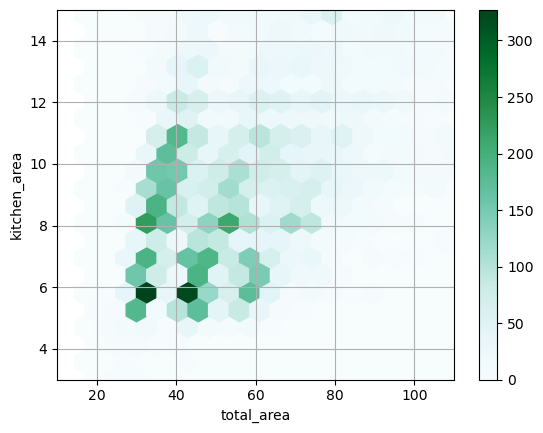

In [8]:
# распределение площади кухни относительно общей площади квартиры
data.plot(
    x='total_area', y='kitchen_area', kind='hexbin',
    gridsize=170, xlim=(10,110), ylim=(3,15), sharex=False, grid=True)

В зависимости явно просматриваются три "лепестка". Похоже, есть разные типовые квартиры и им соответсвуют свои типовые кухни.
Проверим.

Введем новый столбец в датасет - категория (тип) дома, в зависимости от высоты потолка. Определим категории домов так:
- Хрущевка: потолки не выше 2.5 м
- Брежневка: потолки в диапазоне (2.5, 2.6] м
- Панелька: потолки более (2.6, 2.8] м
- Сталинка: потолки выше 2.8 м

Если предположение верно, то в каждом типе дома будет преобладать один "лепесток" из диаграммы распределения.

Хрущевка корреляция: 0.49642946623643414
Медиана: 7.0
Брежневка корреляция: 0.44309861501364245
Медиана: 8.0
Панелька корреляция: 0.6080644159267458
Медиана: 10.8
Сталинка корреляция: 0.5317581023112071
Медиана: 11.7


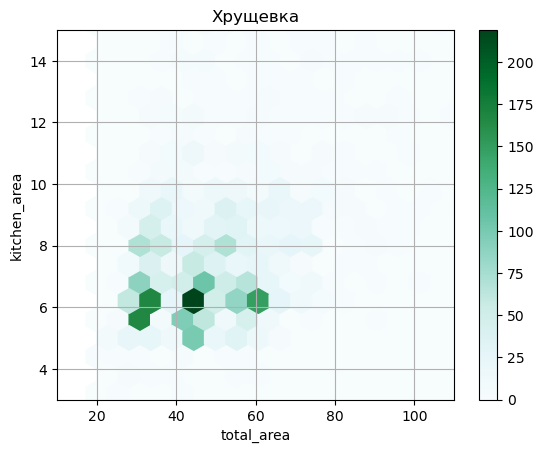

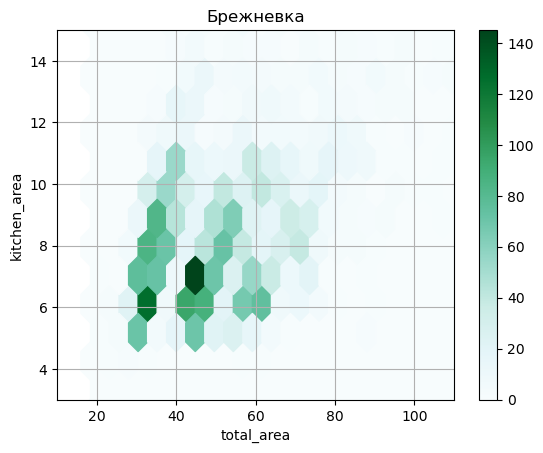

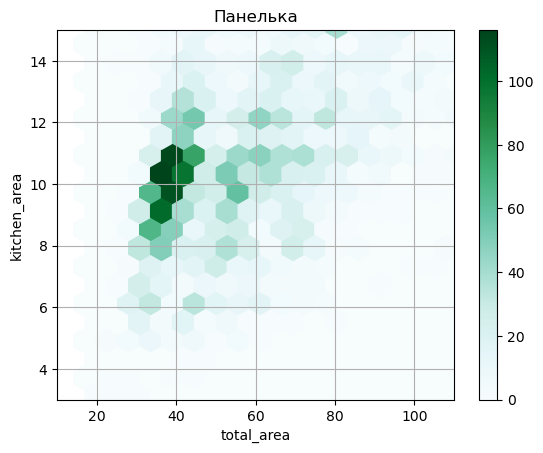

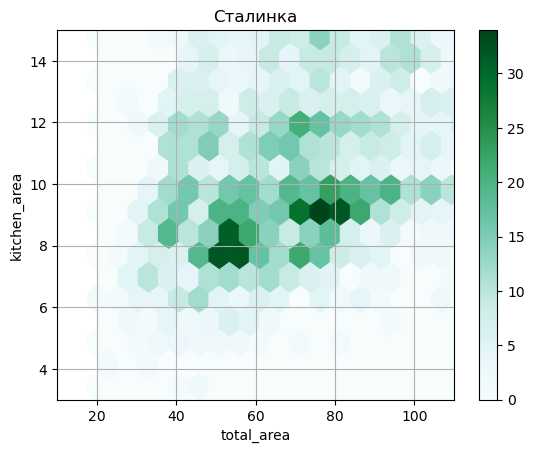

In [9]:
# Вводим новый столбец в датасет - категория дома, в зависимости от высоты потолка.
def category_ceil(raw):
        if raw['ceiling_height'] > 2.8:
            return 'Сталинка'
        elif raw['ceiling_height'] <= 2.5:
            return 'Хрущевка'
        elif raw['ceiling_height'] <= 2.6:
            return 'Брежневка'
        return 'Панелька'

# в датасете появляется новый столбец с типом дома        
data['building_type'] = data.apply(category_ceil, axis=1)  

# Отдельно посмотрим для каждой категории дома что дает хексбин

data[data['building_type']=='Хрущевка'].plot(
   x='total_area', y='kitchen_area', kind='hexbin', title = 'Хрущевка',
    gridsize=70, xlim=(10,110), ylim=(3,15), sharex=False, grid=True)

data[data['building_type']=='Брежневка'].plot(
    x='total_area', y='kitchen_area', kind='hexbin', title = 'Брежневка',
    gridsize=40, xlim=(10,110), ylim=(3,15), sharex=False, grid=True)

data[data['building_type']=='Панелька'].plot(
    x='total_area', y='kitchen_area', kind='hexbin', title = 'Панелька',
    gridsize=160, xlim=(10,110), ylim=(3,15), sharex=False, grid=True)

data[data['building_type']=='Сталинка'].plot(
    x='total_area', y='kitchen_area', kind='hexbin', title = 'Сталинка',
    gridsize=120, xlim=(10,110), ylim=(3,15), sharex=False, grid=True)
# медианное значение площади кухни для каждого типа дома, записывается в словарь с соотв. ключом
medians = {}
# посмотрим корреляции и медианы
for building_type in ['Хрущевка', 'Брежневка', 'Панелька', 'Сталинка']:
    print (building_type, 'корреляция:', data[data['building_type']==building_type]['total_area'].corr(data[data['building_type']==building_type]['kitchen_area']))
    medians[building_type] =  data[data['building_type'] == building_type]['kitchen_area'].median() # словарь, хранящий медианы для каждого типа здания
    print ('Медиана:', medians[building_type])
plt.show()

# заполняем пропуски в площади кухни в зависимости от типа дома
for building_type in ['Сталинка', 'Хрущевка', 'Брежневка', 'Панелька']:
    data.loc[data['building_type'] == building_type,'kitchen_area'] = data.loc[data['building_type'] == building_type,'kitchen_area'].fillna(medians[building_type])
# вопрос ревьюеру. Как написать конструкцию выше поэлегантнее, чтобы кровь из глаз не капала?    

# Медиана в сталинке какая-то странная, великовата на глаз. Поглядим еще на гистограмму по сталинкам
#data[data['building_type'] == building_type]['kitchen_area'].hist(bins=50, range=[3,20])
# Понятно, длинный хвост смещает медиану вправо относительно самых распространенных значений. забьем на эту проблему.

Нельзя сказать, что гипотеза чисто и красиво подтвердилась.  Да и корреляция вышла так себе, не супер (во всех случаях около 0.5). Но все равно полезное можно добыть.

Медианные значения площади кухни критично зависят от категории дома (Хрущевка - 7 м2, Брежневка - 8 м2, Панелька - 10.8 м2, Сталинка- 11.7 м2).

Основные тенденции:
- В хрущевках площадь кухни самая маленькая (6 м2) и слабо зависит от размера квартиры.
- В брежневках площадь кухонь варьируется сильнее всего и при этом не сильно зависит от размера квартиры. Распределение похоже на исходное (без учета типа дома). Брежневки дают самый сильный вклад в центральный лепесток распределения.
- в панельках кухни маленькие (в основном это левый лепесток исходного распределения). Площадь кухни увеличивается с общей площадью квартиры
- В сталинках площадь кухни большая (8-12 м2), варьируется не сильно и возрастает с общей площадью. Сталинки - это правый лепесток распределения.


То есть, если у нас пропуск в площади кухни, то следующий шаг - смотрим к какой категории относится дом. *В идеале - надо сделать какую-нибудь апрокисмацию для каждого типа дома и вставлять площадь кухни в зависимости от общей площади квартиры.*

Но пока сделаем быстрый вариант - просто медиану по каждому типу.

**Причины, которые могли привести к пропускам в данных (раздел 2.1)**

Пропуски в столбцах, заполняемым пользователем, могут появляться, потому что пользователь:
- не заполнил данные об остуствующей зарактеристике (например, вместо того, чтобы написать "0" в разделе количество балконов или прудов, он пропустил эти строки)
- не заполнил данные, потому что их не знает (например, жилую площадь квартиры) или они неизвестны (площадь кухни при открытой планировке)
- не предоставил точный адрес для определения картографических данных
- информация не является принципиально важной (например, если рядом с домом есть пруд, то это важно указать. А если нет - то и раздел о прудах пропускают)
- не виноват. В столбце days_exposition пропуски могут быть связаны с тем, что квартира еще не продана к моменту выгрузки датасета

В days_exposition посмотрим на пропуски по годам, вдруг тоже есть закономерность

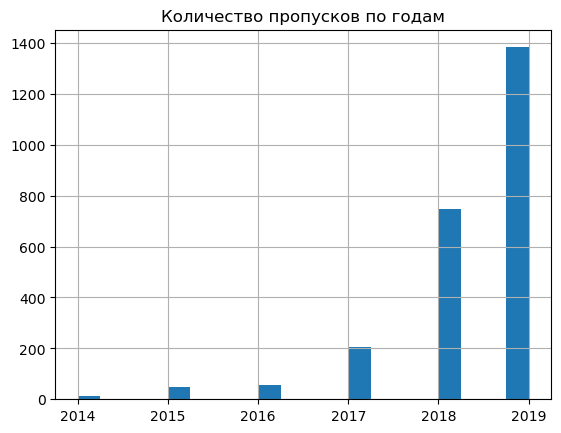

Text(0.5, 1.0, 'Нормализованное количество по годам')

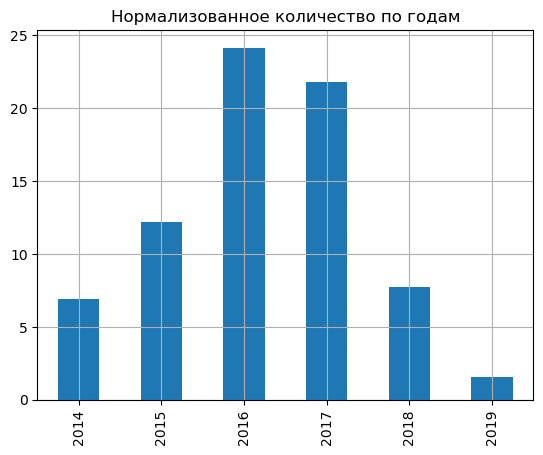

In [10]:
# сейчас посмотрим
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
x = data[data['days_exposition'].isna()]['first_day_exposition'].dt.year.hist(bins=20)
x.set_title('Количество пропусков по годам')
# И правда, чем новее объявление, тем больше пропусков в графе days_exposition.
# это может связано не только с тем, что еще не успели продаться квартиры. Может быть просто количество объявлений выросло пропорционально?
# надо смотреть нормированные величины: количество_пропусков_в_год/количество_объявлений_в_год
missed = data[data['days_exposition'].isna()]['first_day_exposition'].dt.year.value_counts()
total = data['first_day_exposition'].dt.year.value_counts()
plt.show()
x_norm = total.divide(missed).plot(kind='bar', grid = True)
x_norm.set_title('Нормализованное количество по годам')

Действительно. С каждым годом количество пропусков в графе "first_day_exposition" растет!
Логично было бы думать, что скачок пропусков в последний год связан с тем, что многие квартиры еще не успели продать. Но Если произвести нормировку на количество объявлений по годам, оказывается, что дело не в этом


**2.2 Изменение типов данных**

In [11]:

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

data = data.astype({'total_images': 'Int8',
                    'rooms': 'Int8',
                    'floors_total': 'Int8',
                    'floor': 'Int8',
                    'is_apartment': 'bool',
                    'balcony': 'Int8',
                    'airports_nearest': 'Int32',
                    'cityCenters_nearest': 'Int32',
                    'parks_around3000': 'Int8',
                    'parks_nearest': 'Int32',
                    'ponds_around3000': 'Int8',
                    'ponds_nearest': 'Int32',
                    'days_exposition': 'Int16'
                   }, errors='ignore')
#data.info() # проверка все ли получилось

Тип столбцов нужно изменить на более уместный, потому что это экономит ресурсы и в некоторых случаях позволяет избежать ошибок при дальшейшей обработке данных (тут, например, is_apartment - явно булев тип, а не object, как был изначально заявлен).
Есть целочисленные данные, которые не имеет смысл хранить под типом float (например, количество комнат, этажей, балконов), более того, там и большая разрядность не нужна, эти величины не принимают очень больших значений.

**2.3 Устранение неявных дубликатов**

In [12]:
# откомментировав код ниже, можно посмотреть уникальные значения названий населенных пунктов в этом датасете
#print(data['locality_name'].unique())
#print(data['locality_name'].value_counts().head(60))

print('Всего населенных пунктов:', len(data['locality_name'].unique()))

# заменяем все ё на е. По современным правилам можно.
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

# убираем все названия типов населенных пунктов
for town_lable in ['поселок городского типа ', 'городской поселок ', 'поселок при железнодорожной станции ', 'поселок станции ', 'коттеджный поселок', 'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'деревня ', 'поселок ', 'село ']:
    data['locality_name'] = data['locality_name'].str.replace(town_lable, '')

print('Всего населенных пунктов после фильтра:', len(data['locality_name'].unique()))

# посмотреть какие населенные пункты получились:
#print(data['locality_name'].value_counts().head(100)) #можно полюбоваться на новый ассортимент названий
#sorted(data['locality_name'].unique())

Всего населенных пунктов: 284
Всего населенных пунктов после фильтра: 242


Может показаться, что остались дубли: 
Кузьмолово' и 'Кузьмоловский', 'Кингисеппский' и 'Кингисепп', 'Курковицы' и 'Куровицы'.
Но судя по карте - это все разные населенные пункты, поэтому их не сливаем.

**2.4 Устранение редких и выбивающихся значений**

**цены на квартиры**

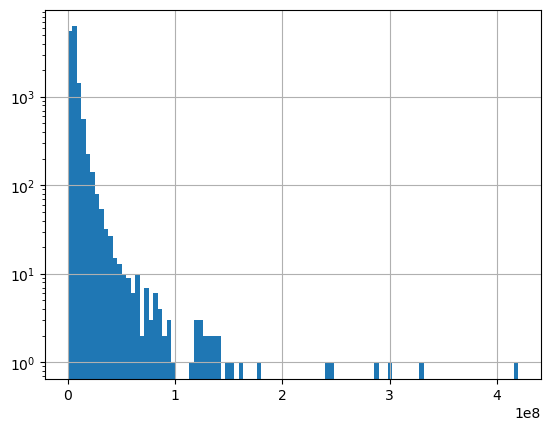

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,building_type
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7,218.0,7,False,...,0,Санкт-Петербург,32440,5297,0,<NA>,2,198,199.0,Сталинка
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7,182.8,4,False,...,0,Санкт-Петербург,33143,6235,3,400,3,140,249.0,Сталинка
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6,63.7,6,False,...,0,Санкт-Петербург,22494,1073,3,386,3,188,NaN,Сталинка
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7,258.0,5,False,...,0,Санкт-Петербург,32440,5297,0,<NA>,2,198,111.0,Сталинка
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.0,5,False,...,0,Санкт-Петербург,23011,1197,3,519,3,285,233.0,Сталинка
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,False,...,0,Санкт-Петербург,30706,7877,0,<NA>,2,318,106.0,Панелька


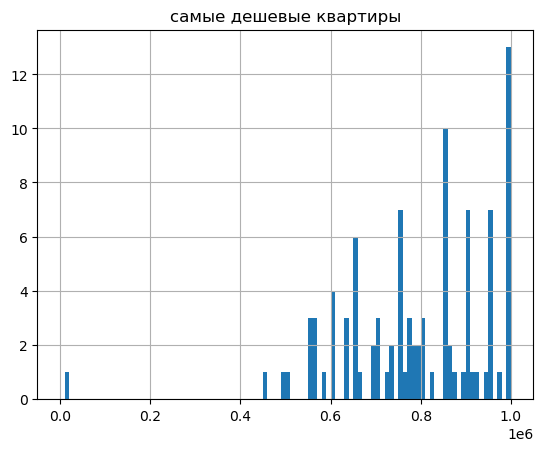

In [13]:
# пойдем по порядку по всем столбцам
#data.info()

# last_price: цены на квартиры. 
data['last_price'].hist(bins=100, log=True)
plt.show()
display(data[data['last_price']>200e6].sort_values(by='last_price')) # проверка самых дорогих квартир (более 200млн руб). Дорого, конечно. Но можно поверить: либо огромная площадь, либо в самом центре города.
data['last_price'].hist(bins=100, range=(0, 1000000)) # самые дешевые квартиры. Что-то рядом с нулем можно выкинуть
plt.title('самые дешевые квартиры')
data = data[data['last_price']>data['last_price'].min()] # выкидываем минимальное значение

Ну и цены. Но, с другой стороны, 400млн за 12 комнат и 900метров на 25 этаже - наверное адекватно. Да и продали не сразу эту квартиру. Оставляем все цены, кроме одной - около нуля (эта точка явно выпадает)

**общая площадь квартир**

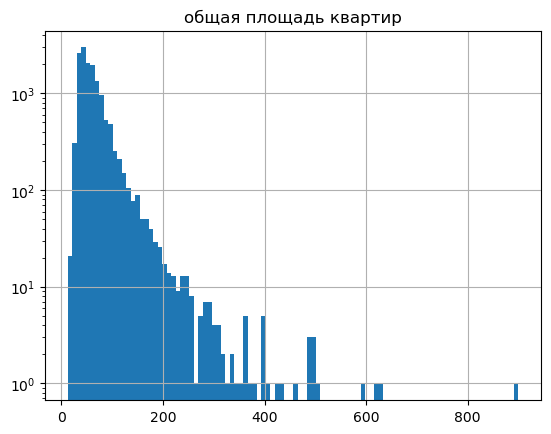

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,building_type
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,...,0,Санкт-Петербург,30706,7877,0,<NA>,2,318,106.0,Панелька


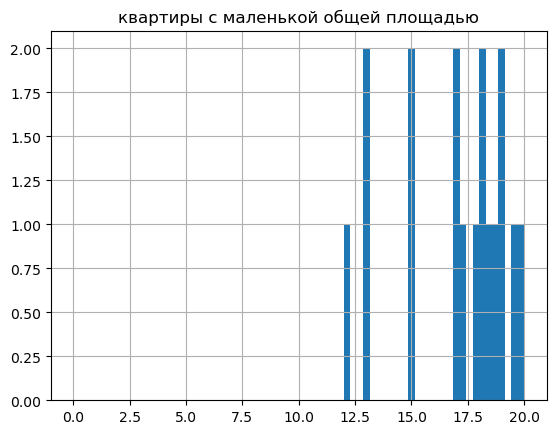

In [14]:
# total_area: общая площадь квартир
data['total_area'].hist(bins=100, log=True) # в области больших значений все прилично
plt.title('общая площадь квартир')
plt.show()
display(data[data['total_area']==data['total_area'].max()]) #самая большая квартира (мы уже ее встречали). Объявление адекватно выглядит. Оставляем.

# маленькие квартиры: 
data['total_area'].hist(bins=70, range=(0,20), log=False) #довольно много предложений крошечных квартир с площадью больше 17м2 
plt.title('квартиры с маленькой общей площадью')
plt.show()
# квартир с площадью менее 17м2 уже мало и выглядят эти объявления странно - например, там жилая площадь частенько больше общей. Их можно удалить
#display(data[data['total_area']<17]) #квартиры с площадью менее 17 м2
data=data[data['total_area']>17] #оставляем только те объявления, где общая площать больше 17м2


общая площадь квартир доходит до 600 м2 и более. Есть квартира с площадью 900 м2, она выглядит как явный выброс. Но при детальном рассмотрении никаких явных аномалий в этом объявлении нет, поэтому его оставляем.
В области малых площадей много предложений квартир с площадью более 17 м2, судя по количеству предложений - это реальные данные. А вот объявления, где общая площадь менее 17 м2 содержат в себе противоречия (например, там жилая площадь или площадь кухни больше общей), поэтому их удаляем.


**количество комнат**

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,building_type
18848,6,28500000.0,270.0,2015-03-02,16,3.0,4,180.0,4,False,...,1,Санкт-Петербург,23575,4142,1,516,0,<NA>,1365.0,Сталинка


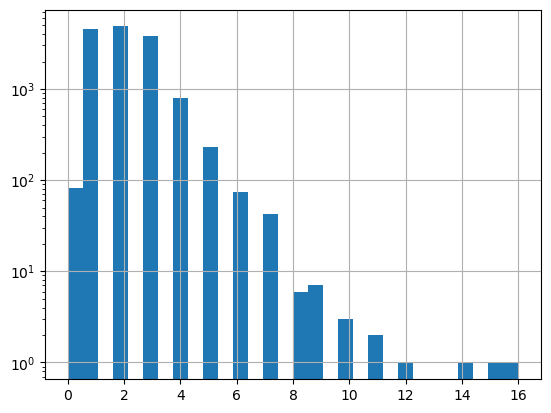

In [15]:
# rooms: количество комнат
data['rooms'].hist(bins=30, log=True) # больше всех вылезает 15-16 комнат. Такое бывает?
display(data[data['rooms']==data['rooms'].max()]) # огромные площади и цена соответствует. Стану аналитиком - куплю такую квартиру.
# ничего не стираем.

**высота потолков**

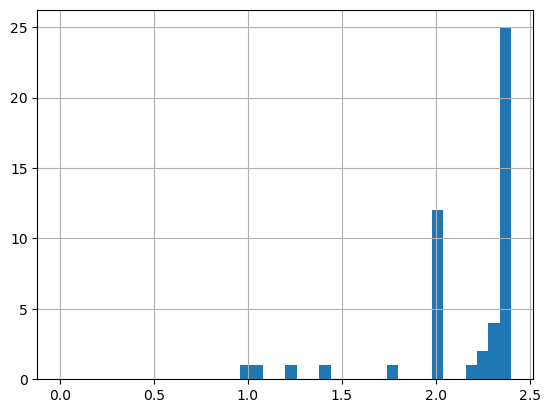

In [16]:
# ceiling_height: потолки
# слишком высокие уже обработаны ранее. Посмотрим что там с низкими.
data['ceiling_height'].hist(bins=40, range=(0,2.4)) # вряд ли бывают потолки меньше двух метров. Выкинем их.
data = data[data['ceiling_height'] > 2]

Удалили записи с потолками менее 2м

**этажность дома**

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,building_type
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,0,Кронштадт,67763,49488,2,342,3,614,166.0,Сталинка
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,0,Санкт-Петербург,20728,12978,1,793,0,<NA>,45.0,Панелька


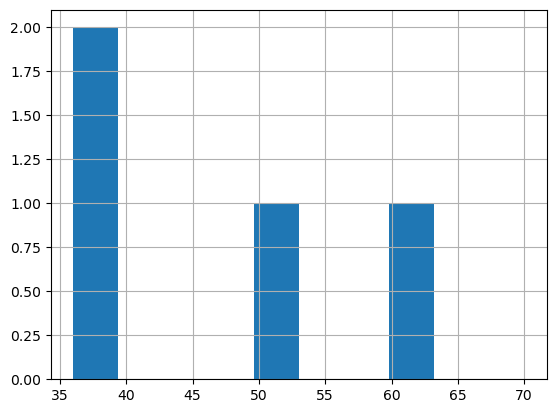

In [17]:
# floors_total: этажность дома
data['floors_total'].hist(range=(36,70),log=False) #проверка, что там с высокой этажностью
display(data[data['floors_total']>40])               #две квартиры в домах 50-60 этажности.
#Сами квартиры по остальным характеристикам - вполне затрапезные.
#Бешеная этажность - похожа на ошибку, логично ее сделать тоже стандартной.
data.loc[data['floors_total']>40,'floors_total'] = data['floors_total'].median() # вместо этажей 50 и 60 вставили медианный
#data['floors_total'].hist() # проверка что все ок

Убрали два объявления с этажностью домов 50-60 эт. Сами квартиры должны быть в таких небоскребах нестандартные, чего не наблюдалось.

**жилая площадь**

<AxesSubplot:>

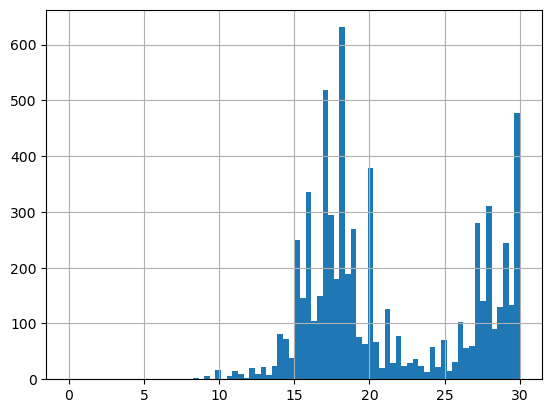

In [18]:
#living_area, floor, is_apartment - все вроде нормальные
data['living_area'].hist(bins=80, range=(0,30)) # среди "маленьких" плодащей - два явных пика распределения. Причем, первый - около 17м2 (такие квартиры бывают?)
# судя по количеству предложений, такие маленькие квартиры все-таки бывают. Но меньше 10м2 - совсем странно. Посмотрим на них.
#display(data[data['living_area']<10]) #не видно сильных странностей


В распределении "маленьких" площадей квартир есть два явных пика и первый имеет максимум на 17м2 - ну очень маленькая площадь. Несмотря на это, у квартир с такой площадью никаких явных странностей нет, поэтому оставляем.

**площадь кухни**

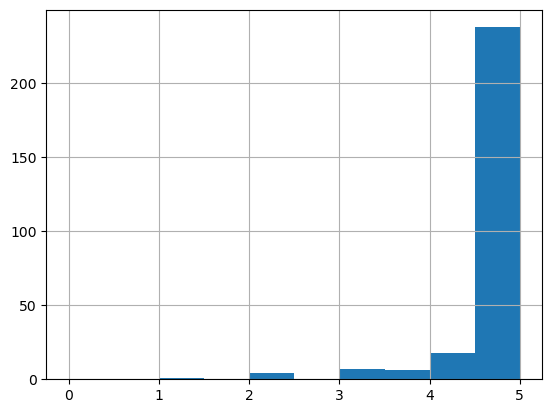

In [19]:
# kitchen_area 
data['kitchen_area'].hist(range=(0,5))
data = data[data['kitchen_area'] > 4] #ну не может быть кухня меньше четырех метров


Выкинула жилье с кухнями менее 4м2. В таких квартирах можно умереть с голоду, не место им в датасете.

В остальных колонках без изменений. Код ниже, можно раскомментировать кусочки и посмотреть иллюстрации.

In [20]:
# balcony вполне разумно
#data['balcony'].value_counts()

# airports_nearest  расстояние до ближайшего аэропорта, норм
#data['airports_nearest'].hist(range=(0,200)) #одна квартира в здании аэропорта
#display(data[data['airports_nearest'] == 0]) #эта квартира на расстоянии примерно 23км от центра города. Похоже и правда, в пулковском терминале. Оставим.
#data['airports_nearest'].hist(bins=50, range=(60e3,90e3)) # можно поверить

# cityCenters_nearest   тоже норм
#data['cityCenters_nearest'].hist(bins=50, range=(0, 3000)) # верю (с)

# parks_around3000 and ponds_around3000 и тут все ок
#print('parks:\n', data['parks_around3000'].value_counts(), sep='')
#print('pondes:\n', data['ponds_around3000'].value_counts(), sep='') # с парками и прудами все норм

# parks_nearest and ponds_nearest
# data['ponds_nearest'].hist(bins=50,range=(0,100)) #минимальное расстояние от дома до водоема - 50м (ВК РФ :)
# можно было бы удалить все обьявления где квартиры ближе, чем 50м (все равно по закону они под снос)
# но мы так делать не будем. Потому что распределение похоже на нормальное, а значит, похоже на правду.
#data['parks_nearest'].hist(bins=50) # вроде ок. Есть длинный хвост - но почему б и нет.

#days_exposition  
#data['days_exposition'].hist() # и тут ок

**Общие выводы по обработке аномалий**
- Оставлены все цены, кроме одной - около нуля (эта точка явно выпадает). В области высоких цен, есть отдельные предложения за несколько сот миллионов, но эти объявления оставлены, так как выглядят адекватно (большие площади квартир, высокие потолки, близость к центру и тд)
- Общая площадь квартир доходит до 600 м2 и более. Есть квартира с площадью 900 м2, она выглядит как выброс в данных. Но при детальном рассмотрении объявлений никаких явных аномалий нет. В области малых площадей, много объявлений о продаже крошечных квартир с площадью 17 м2 и более, судя по количеству предложений - это реальные данные. А вот объявления, где общая площадь менее 17 м2 содержат в себе противоречия (например, там жилая площадь или площадь кухни больше общей), поэтому их удаляем.
- Высота потолков. Частично было обработана в предыдущем разделе (удалены значения более 50 метров, поделены на десять значения, где пропущена запятая). В этом разделе удалены объявления с потолками менее 2 м.
- Этажность дома. Убрали два объявления с этажностью домов 50-60 эт. Сами квартиры должны быть в таких небоскребах нестандартные, а не одно- или двухкомнатные с общей площадью 40 м2.
- Жилая площадь. В распределении "маленьких" площадей квартир есть два явных пика и первый имеет максимум на 17м2 - ну очень маленькая площадь. Несмотря на это, у квартир с такой площадью никаких явных странностей нет, поэтому ничего удалять не надо. Удалены только объявления с жилой площадью квартир менее 10 м.
- Площадь кухни. Удалены объявления с площадью кухни менее 4 м2. Количество объявлений с большей площадью резко возрастает.
- По остальным столбцам аномалий не выявлено.

### Посчитайте и добавьте в таблицу новые столбцы

In [21]:
# цена одного квадратного метра
data['price_m2'] = data['last_price'] / data['total_area']

# день-месяц-год публикации объявления
data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

# тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_categorization(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_categorization, axis=1)

#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
data['cityCenter_km'] = (data['cityCenters_nearest'] / 1000) #.round() #не работает потому что нан не удалены. Я их удалю потом, когда понадобится работать именно с этим столбцом. А пока не буду портить датафрейм.


data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,building_type,price_m2,day,month,year,floor_type,cityCenter_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755,NaN,Панелька,120370.370370,3,3,2019,другой,16.028
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48,121.0,Сталинка,100000.000000,1,6,2018,другой,8.098
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,0,<NA>,289.0,Хрущевка,88524.590164,6,2,2017,другой,15.008
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,2,553,137.0,Панелька,127525.252525,3,11,2017,другой,13.878
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,3,298,366.0,Брежневка,82943.925234,5,7,2017,последний,33.058
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,0,<NA>,397.0,Сталинка,81707.317073,3,11,2017,первый,10.698
18,8,3250000.0,31.0,2017-01-27,1,2.50,5,19.4,2,False,...,0,<NA>,168.0,Хрущевка,104838.709677,4,1,2017,другой,10.842
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,0,<NA>,97.0,Панелька,117355.371901,2,1,2019,другой,12.843
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,0,<NA>,74.0,Панелька,76500.000000,3,9,2017,другой,19.311
22,20,5000000.0,58.0,2017-04-24,2,2.75,25,30.0,15,False,...,0,<NA>,60.0,Панелька,86206.896552,0,4,2017,другой,<NA>


### Исследовательский анализ данных

**4.1 изучение каждого из параметров**

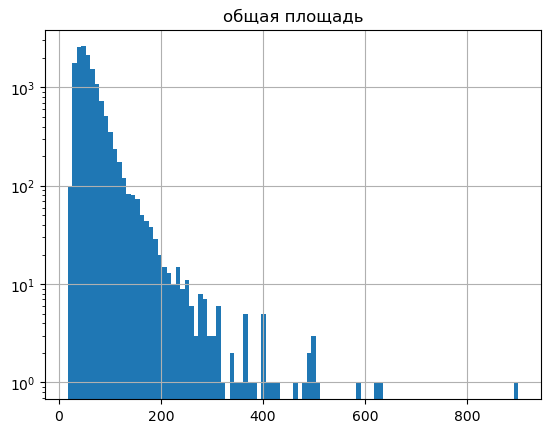

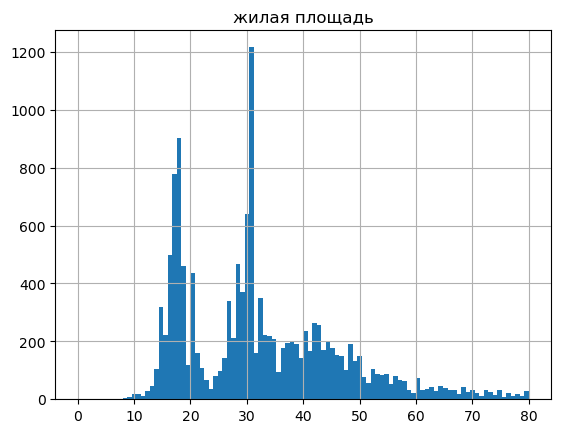

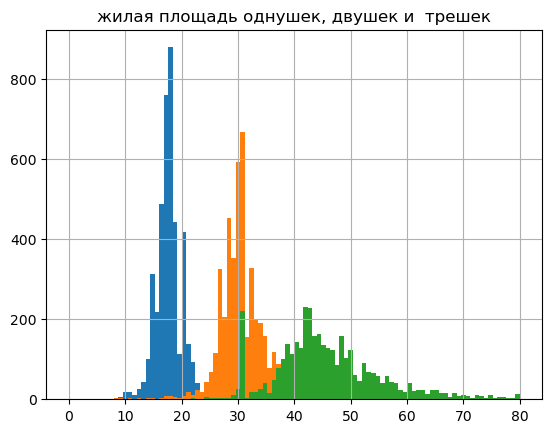

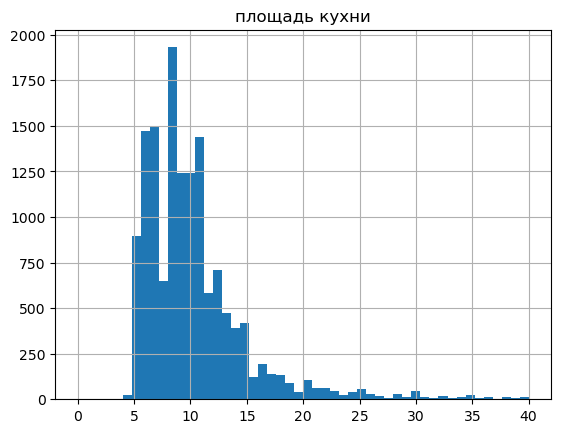

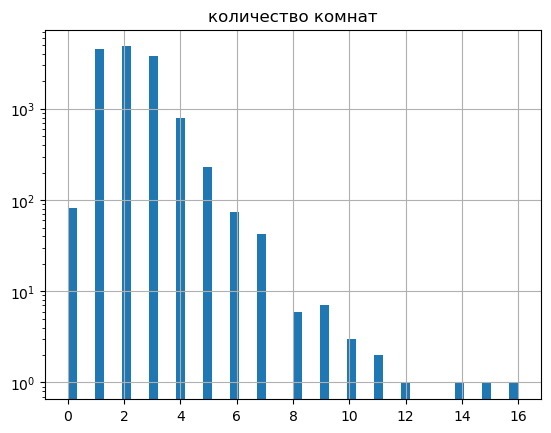

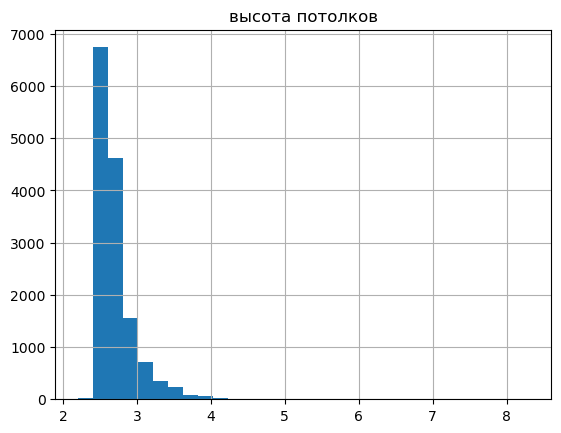

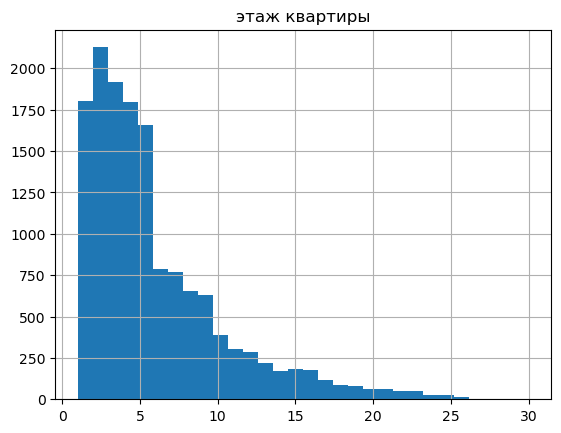

распределение квартир по этажам:
другой       10562
последний     2080
первый        1805
Name: floor_type, dtype: int64


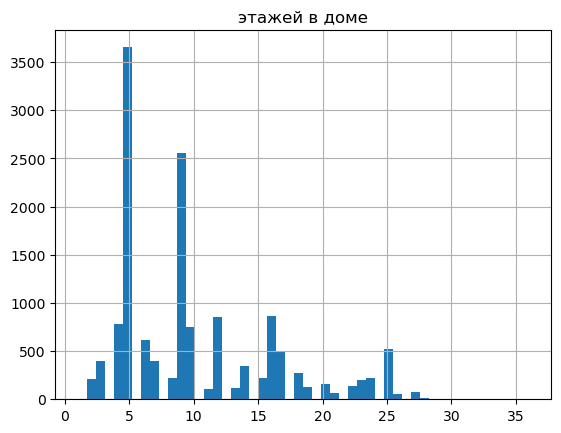

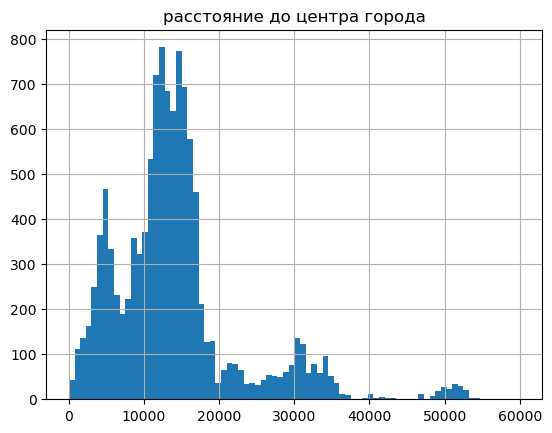

Санкт-Петербург    10070
Всеволожск           271
Пушкин               233
Мурино               227
Шушары               215
Колпино              203
Кудрово              194
Гатчина              149
Name: locality_name, dtype: int64

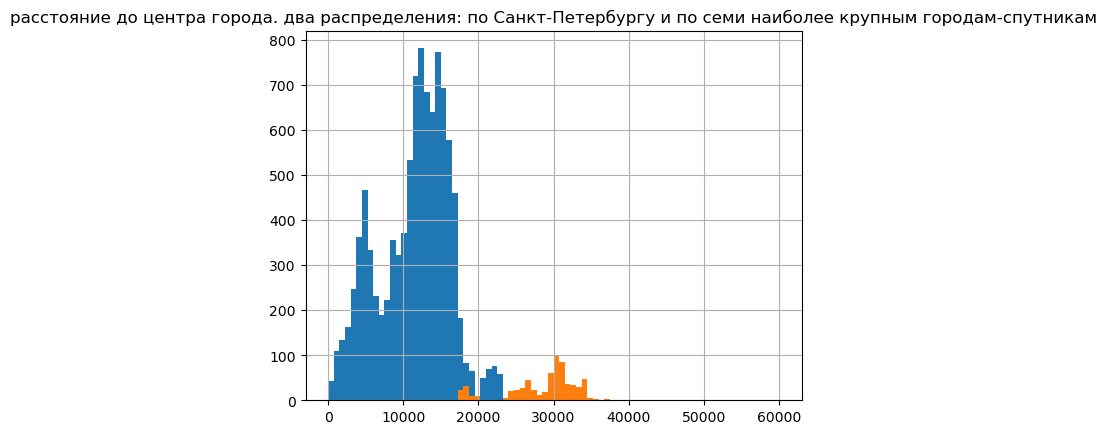

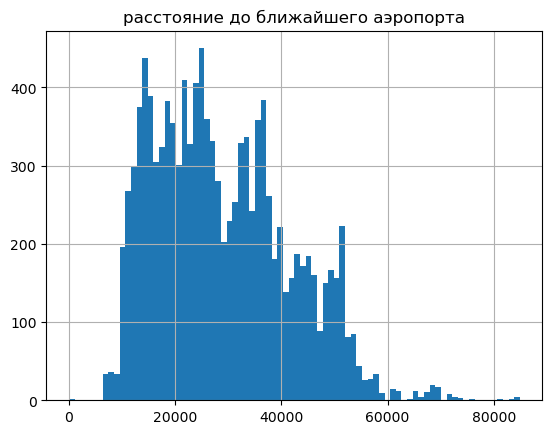

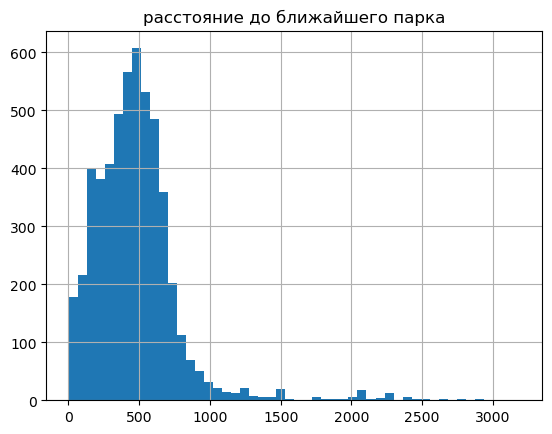

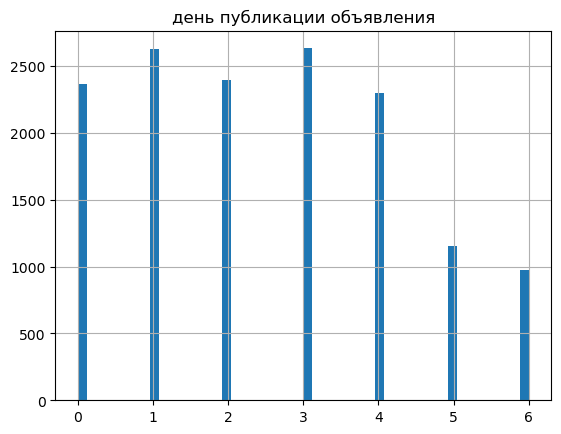

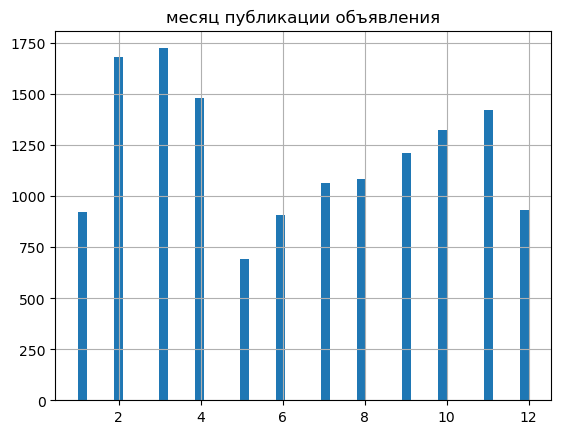

In [22]:
# общая площадь
data['total_area'].hist(bins=100, log=True)
plt.title('общая площадь')
plt.show()
# Пуассоновское распределение с одной выскочившей точкой (та самая квартира 900м2) и странным скоплением в области 500м2

# жилая площадь
data['living_area'].hist(bins=100, range=(0,80), log=False)
plt.title('жилая площадь')
plt.show()
# жилая площадь может достигать 400м2. Основное жилье имеет площадь до 100м2.
# в этой области сложная структура распределения по плодащам: два узких пика (центры на 17м2 и 30м2) накладываются на один размазанный (центр около 42м2)
# возмжожно, этим распределениям соответствуют 1- 2- 3- комнатные квартиры.
data[data['rooms']==1]['living_area'].hist(bins=100, range=(0,80), log=False)
data[data['rooms']==2]['living_area'].hist(bins=100, range=(0,80), log=False)
data[data['rooms']==3]['living_area'].hist(bins=100, range=(0,80), log=False)
plt.title('жилая площадь однушек, двушек и  трешек') # а легенду можно так же быстро сделать?
plt.show() 
# да, так и есть. В однушках средняя площадь около 17м2, в двушках - 30м2 и в трешках 42м2.

# площадь кухни
data['kitchen_area'].hist(bins=50, range=(0,40), log=False)
plt.title('площадь кухни')
plt.show()

# количество комнат
data['rooms'].hist(bins=50, log=True)
plt.title('количество комнат')
plt.show()
# пуассоновское распределение, больше всего квартир с 1, 2 и 3 комнатами

# высота потолков
data['ceiling_height'].hist(bins=30)
plt.title('высота потолков')
plt.show()

# этаж квартиры
data['floor'].hist(bins=30)
plt.title('этаж квартиры')
plt.show()
# ступеньки в гистограмме указывают на общую этажность домов. Видно, что много квартир в пяти- и девятиэтажках. Далее, после 10 этажа хвост распределения плавный, это значит, что более высокие дома не строились в таких количествах по типовым проектам, их меньше, а ассортимент богаче

# тип этажа квартиры («первый», «последний», «другой»)
print('распределение квартир по этажам:\n', data['floor_type'].value_counts(), sep='')

# общее количество этажей в доме
data['floors_total'].hist(bins=50)
plt.title('этажей в доме')
plt.show()

# расстояние до центра города в метрах
data['cityCenters_nearest'].hist(bins=80,range=(0,60e3))
plt.title('расстояние до центра города')
plt.show()
# откуда несколько наложившихся распределений? надо смотреть по населенным пунктам - может каждый пик соответсвует наиболее густонаселенным районам
# больше всего объявлений в следующих пяти локациях:
popular_localities =  data['locality_name'].value_counts().head(8)
display(popular_localities) # весь жир гистограммы - это Санкт-Петербург
# построим распределения предложений в зависимости от удаленности от центра города, для четырех самых популярных locality_name
data_pop_loc = data[data['locality_name'].isin(popular_localities.index)] #отфильтруем самые популярные локации
data_pop_loc = data_pop_loc[data_pop_loc['locality_name'] != 'Санкт-Петербург'] #выкинем оттуда Санкт-Петербург
data[data['locality_name']=='Санкт-Петербург']['cityCenters_nearest'].hist(bins=80, range=(0,60e3))
data_pop_loc['cityCenters_nearest'].hist(bins=80, range=(0,60e3))
plt.title('расстояние до центра города. два распределения: по Санкт-Петербургу и по семи наиболее крупным городам-спутникам')
plt.show() #гипотеза не подтвердилась. Первые два пика до 20км - это чисто Санкт-Петербург. В локальный максимум на 30км дают небольшой вклад все остальные населенные пункты.

# расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins=80)
plt.title('расстояние до ближайшего аэропорта')
plt.show()

# расстояние до ближайшего парка
data['parks_nearest'].hist(bins=50)
plt.title('расстояние до ближайшего парка')
plt.show()

# день и месяц публикации объявления
data['day'].hist(bins=50)
plt.title('день публикации объявления')
plt.show()

data['month'].hist(bins=50)
plt.title('месяц публикации объявления')
plt.show()

**Выводы по исследовательскому анализу (раздел 4.1)**

- Общая площадь квартир. Квартиры имеют пуассоновское распределение с одной выскочившей, но реальной точкой (одна из самых дорогих квартир площадью 900 м2). Видно неожиданное обилие предложений (7 штук) квартир с общей площадью около 500 м2. Больше всего объявлений о продажи квартир с общей площадью до 100м2.
- По жилой площади квартиры имеют сложную структуру распределения: два узких пика (центры на 17м2 и 30м2) накладываются на один размазанный (центр около 42м2). Этим распределениям соответствуют 1- 2- 3- комнатные квартиры, средняя площадь которых как раз совпадает с "пиками" на гистограмме.
- Подавляющее число квартир в объявлениях имеют площадь кухни в диапазоне 5-15 м2 и высоту потолков до трех метров.
- По количеству комнат распределение квартир похоже на пуассоновское, больше всего квартир с 1, 2 и 3 комнатами.
- Распределение квартир по этажам неравномерное, со ступеньками. Эти ступеньки в гистограмме указывают на общую этажность домов. Видно, что много квартир в пяти- и девятиэтажках. Далее, после 10 этажа хвост распределения плавный, это значит, что более высокие дома не строились в таких количествах по типовым проектам, их меньше, а их ассортимент богаче.
- Предыдущий вывод подтверждается данными об общей этажности домов. Видны всплески, указывающие на большое количество 5- и 9-этажек. Еще есть локальные максимумы в области 16-18 и 25 этажных домов.
- Расстояние до центра города: сложная структура у распределения, несколько наложившихся друг на друга нормальных распределений разной амплитуды и ширины. Первые два пика (самые интенсивные), с центром около 5 км и около 10-15 км - это квартиры в Санкт-Петербурге.  Возможно, провал между этими пиками связан с ассиметрией города и с тем, что как раз на расстоянии порядка 5 км на западе город резко заканчивается будучи ограниченным Финским заливом. Второй, самый интенсивный пик (10-15 км) приблизительно соответствует расстоянию до КАДа, то есть, черте города. Третий пик предложений соотвествует интегрально семи самым крупным городам-спутникам (Всеволожск, Пушкин, Мурино, Шушары, Колпино, Кудрово, Гатчина), которые лидируют по количеству объявлений. Четвертый пик распределения находится на расстоянии 50км, это совпадает с расстоянием до Санкт-Петербургского южного полукольца. Возможно, в области этой магистрали повышенная плотность населенных пунктов с многоквартирной застройкой.
- Расстояние до аэропорта. Очень широкое распределение, практически равномерное в пределах 40км, и спадающее в ноль только в области 60км.
- Рядом с большинством квартир в полукилометре есть парк.
- Дата публикации объявления. В выходные дни объявления публикуют в 2-2.5 раза реже, чем в будние. Самые популярные месяцы для публикации объявлений - это февраль и март, а самые непопулярные - это начало лета (май-июнь) и новый год (декабрь-январь).

**4.2 как быстро продавались квартиры**

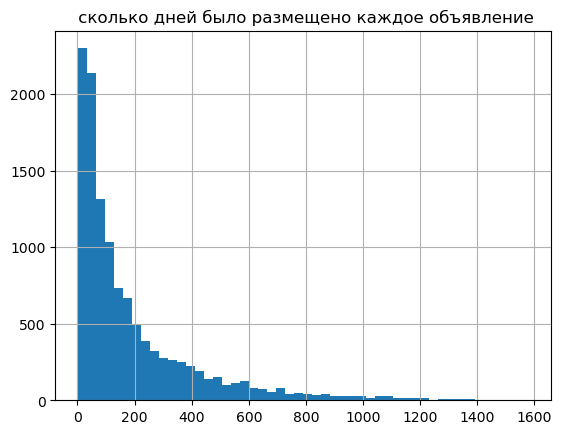

count    12001.000000
mean       190.773436
std        228.959991
min          1.000000
25%         45.000000
50%        104.000000
75%        248.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [23]:
data['days_exposition'].hist(bins=50)
plt.title(' сколько дней было размещено каждое объявление')
plt.show()
data['days_exposition'].describe()

На продажу квартиры уходит примерно 200 дней. Быстрыми можно считать те продажи, которые произошли сразу же после публикации объявления, а слишком долгими - те, которые занимают более 500 дней.

**4.3 Какие факторы больше всего влияют на общую (полную) стоимость объекта**

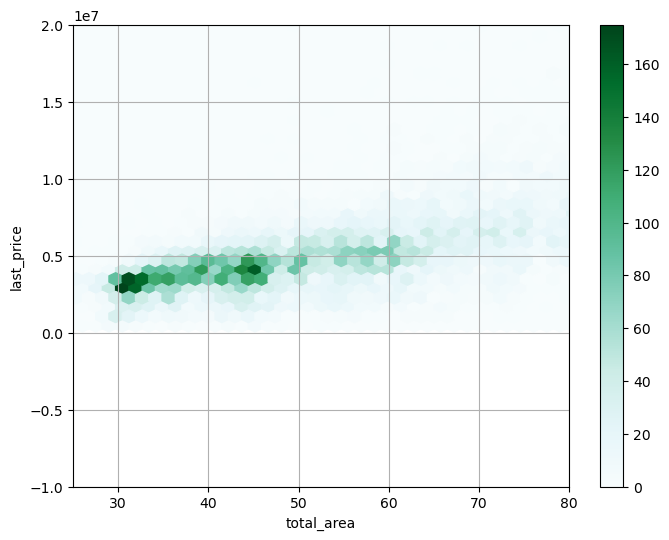

коэффицент корреляции между ценой и общей площадью: 0.7132330661535407


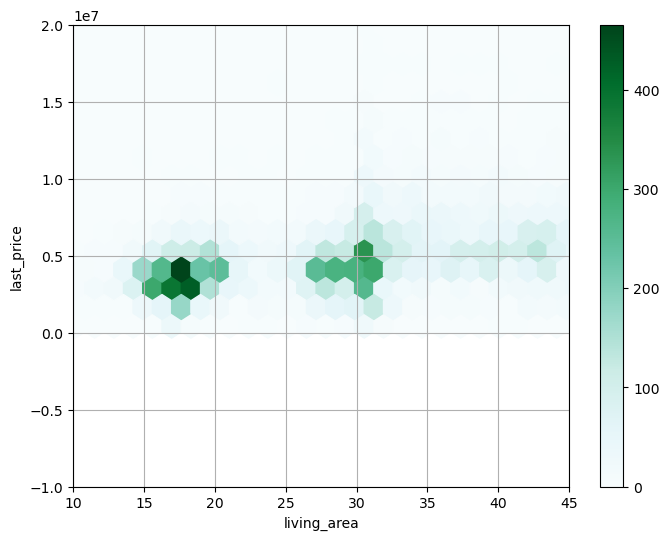

коэффицент корреляции между ценой и жилой площадью: 0.5908951360286591


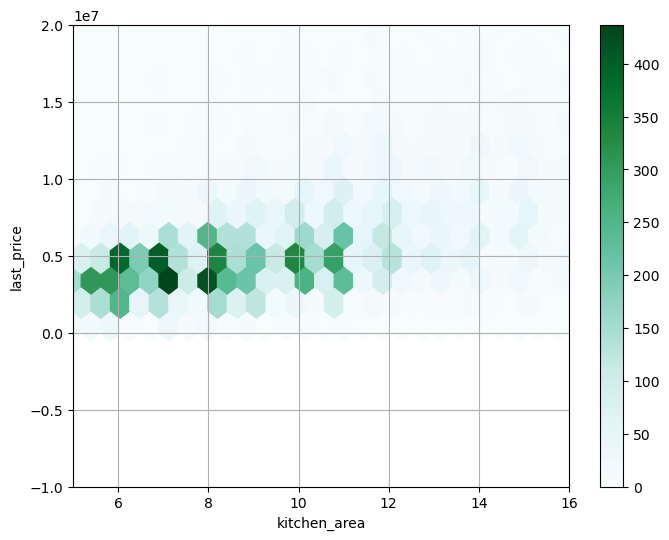

коэффицент корреляции между ценой и площадью кухни: 0.5184255655963499

зависимость медианной цены от этажа квартиры:
             last_price
floor_type            
другой       5000000.0
первый       4100000.0
последний    4540000.0

Матрица корреляций для цены, количества комнат, даты размещения объявления
             last_price     rooms       day     month      year
last_price    1.000000  0.401283 -0.015893  0.004603 -0.055318
rooms         0.401283  1.000000 -0.011291  0.002712 -0.066930
day          -0.015893 -0.011291  1.000000 -0.007166 -0.002795
month         0.004603  0.002712 -0.007166  1.000000 -0.301947
year         -0.055318 -0.066930 -0.002795 -0.301947  1.000000


In [24]:
# зависимость цены от
# общей площади
data.plot(x='total_area', y='last_price', gridsize=600,
          xlim=(25, 80), ylim=(-10e6, 20e6), kind='hexbin', figsize=(8,6), sharex=False, grid=True
          )
plt.show()
print('коэффицент корреляции между ценой и общей площадью:', data['last_price'].corr(data['total_area']))

# жилой площади
data.plot(x='living_area', y='last_price', gridsize=300,
          xlim=(10, 45), ylim=(-10e6, 20e6), kind='hexbin', figsize=(8,6), sharex=False, grid=True
          )
plt.show()
print('коэффицент корреляции между ценой и жилой площадью:', data['last_price'].corr(data['living_area']))

# площади кухни
data.plot(x='kitchen_area', y='last_price', gridsize=250,
          xlim=(5, 16), ylim=(-10e6, 20e6), kind='hexbin', figsize=(8,6), sharex=False, grid=True
          )
plt.show()
print('коэффицент корреляции между ценой и площадью кухни:', data['last_price'].corr(data['kitchen_area']))
print()

# этажом
print('зависимость медианной цены от этажа квартиры:\n', pd.pivot_table(data, index='floor_type', values='last_price', aggfunc='median'))
print()

# количества комнат, этажом, датой размещения (день недели, месяц, год)
#pd.plotting.scatter_matrix(data[['last_price','rooms','floor']], figsize=(9, 9)) #каша какая-то
print('Матрица корреляций для цены, количества комнат, даты размещения объявления\n',data[['last_price','rooms','day','month','year']].corr())


#pivot_flors_rooms = data.pivot_table(index='floor', columns='rooms', values='last_price')

Среди всех рассмотренных параметров, наиболее сильно определяет стоимость объекта его общая площадь (коэфф. корреляции 0.7). Жилая площадь, площадь кухни, количество комнат тоже влияют, но меньше (коэф. корреляции, соответственно, 0.6, 0.5 и 0.4). Совсем не влияет на цену дата публикации объявления (день, месяц, год). Квартиры на первом этаже дешевле, чем на последнем, а на последнем дешевле, чем посередине (категория 'другой' этаж).

2     4832
1     4580
3     3784
4      800
5      231
0       81
6       74
7       43
9        7
8        6
10       3
11       2
14       1
15       1
16       1
12       1
Name: rooms, dtype: Int64


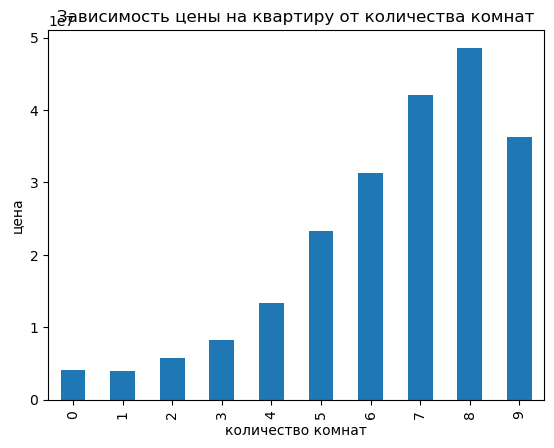

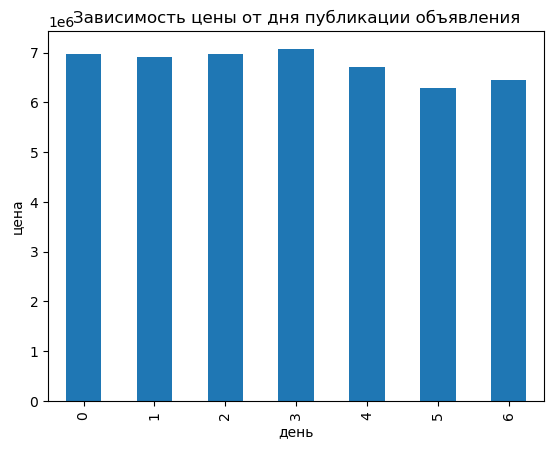

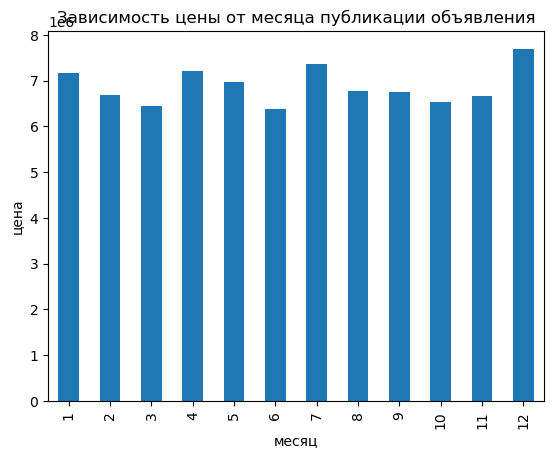

Text(0, 0.5, 'цена')

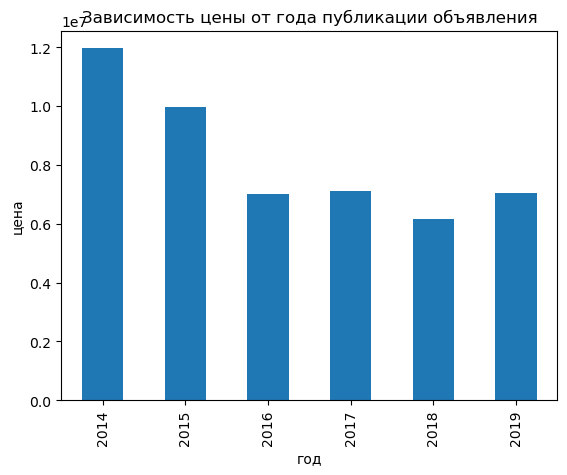

In [25]:
%matplotlib inline
print(data['rooms'].value_counts()) #десятикомнатных три штуки, дальше - меньше. Поэтому все больше десяти нас не интересует.
ax_r = data[data['rooms']<10].groupby('rooms')['last_price'].mean().plot(x='rooms', y='mean', kind='bar')
ax_r.set_title('Зависимость цены на квартиру от количества комнат')
ax_r.set_xlabel('количество комнат')
ax_r.set_ylabel('цена')
plt.show()
ax_d = data.groupby('day')['last_price'].mean().plot(x='day', y='mean', kind='bar')
ax_d.set_title('Зависимость цены от дня публикации объявления')
ax_d.set_xlabel('день')
ax_d.set_ylabel('цена')
plt.show()
ax_m = data.groupby('month')['last_price'].mean().plot(x='day', y='mean', kind='bar')
ax_m.set_title('Зависимость цены от месяца публикации объявления')
ax_m.set_xlabel('месяц')
ax_m.set_ylabel('цена')
plt.show()
ax_y = data.groupby('year')['last_price'].mean().plot(x='day', y='mean', kind='bar')
ax_y.set_title('Зависимость цены от года публикации объявления')
ax_y.set_xlabel('год')
ax_y.set_ylabel('цена')

Цена на квартиру растет нелинейно с количеством комнат.
    
От дня публикации объявления цена не зависит (равно как и от месяца).
А вот с годами динамика есть, начиная с 2016 года средняя цена продаваемых квартир падала и в 2016 вышла на плато. </div>

**4.4 Средняя цена одного квадратного метра**

In [28]:
# отбираем десять самых популярных населенных пунктов
popular_localities =  data['locality_name'].value_counts().head(10)
data_pop_loc = data[data['locality_name'].isin(popular_localities.index.tolist())] # сделаем новый датасет
price_1m2 = data_pop_loc['last_price'] / data_pop_loc['total_area'] 
data_pop_loc['price_1m2'] = price_1m2
average_price_1m2 = pd.pivot_table(data_pop_loc, index='locality_name', values='price_1m2').sort_values(by='price_1m2')
display (average_price_1m2)
print('Самая высокая стоимость квадратного метра (',round(average_price_1m2['price_1m2'].max()) ,' руб/м2) в городе ', *average_price_1m2[average_price_1m2['price_1m2'] == average_price_1m2['price_1m2'].max()].index, sep='')
print('А самая низкая стоимость квадратного метра (', round(average_price_1m2['price_1m2'].min()) ,' руб/м2) в городе ', *average_price_1m2[average_price_1m2['price_1m2'] == average_price_1m2['price_1m2'].min()].index, sep='')

C:\Users\zhvan\AppData\Local\Temp\ipykernel_9072\322718505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pop_loc['price_1m2'] = price_1m2


,price_1m2
locality_name,
Всеволожск,67434.629936
Гатчина,69992.693801
Колпино,75938.525561
Шушары,79244.869320
Петергоф,85554.144673
Мурино,87643.431569
Парголово,90901.351145
Кудрово,96105.431978
Пушкин,103853.343166


Самая высокая стоимость квадратного метра (115665 руб/м2) в городе Санкт-Петербург
А самая низкая стоимость квадратного метра (67435 руб/м2) в городе Всеволожск


**4.5 Средняя цена каждого километра в г. Санкт-Петербург**

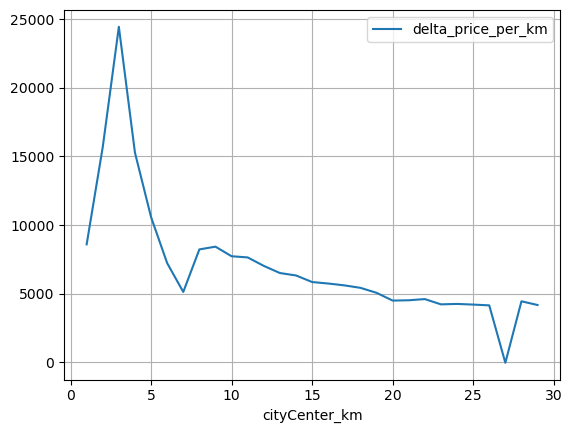

In [27]:
data_piter = data_pop_loc[data_pop_loc['locality_name'] == 'Санкт-Петербург']
data_piter = data_piter.dropna(subset=['cityCenter_km'])

data_piter['cityCenter_km']= data_piter['cityCenter_km'].apply(lambda x: round(x))
price_1km = pd.pivot_table(data_piter, index='cityCenter_km', values='price_1m2')
price_1km['delta_price'] = (price_1km.loc[0] - price_1km)
price_1km['delta_price_per_km'] = price_1km['delta_price'] / price_1km.index
#display(price_1km)
price_1km.index.tolist
price_1km.plot(y='delta_price_per_km', use_index=True, grid=True)
plt.show()

Средняя цена за квадратный метр площади за километр расстояния ведет себя нелинейно в зависимости от удаленности от центра. Километр ближе к центру города (на расстоянии 2-3 км) резко подскакивает в цене (достигает величины 25 000 руб) и стоит в пять раз дороже, чем километр на расстоянии 15-20 км от центра города. Чем дальше от центра города, тем плавнее меняется цена за километр: она падает с 7 000р. на 12-км от центра города до 5 000р. на 19 км.

### Общий вывод

- Половина объявлений - это продажа квартир в черте Санкт-Петербурга в радиусе 20 км (средняя стоимость - 115000 р/м$^{2}$). Остальные квартиры распределены в основном на расстоянии 30 км и 50 км от центра города.
- Основной ассортимент представляют 1- 2- 3-комнатные квартиры с жилой площадью около 17 м$^{2}$, 30 м$^{2}$ и 42 м$^{2}$ соответственно. Вместе с этим, есть предложения о продаже квартир с количеством комнат до 16 и общей площадью 500 м$^{2}$ и более. 
- Подавляющее число квартир в объявлениях имеют площадь кухни в диапазоне 5-15 м2 и высоту потолков до трех метров.
- Большое количество квартир расположено в 5- и 9-этажках. Еще есть локальные максимумы в области 16-18 и 25 этажных домов.
- Общая площадь является определяющим фактором цены квартиры. Цена на квартиру растет нелинейно от количества комнат.
- Средняя цена за квадратный метр площади нелинейно зависит от расстояния квартиры до центра города. Километр ближе к центру города (на расстоянии 2-3 км) резко подскакивает в цене (достигает величины 25 000 руб) и стоит в пять раз дороже, чем километр на расстоянии 15-20 км от центра города. 
- На продажу квартиры уходит примерно 200 дней. Быстрыми можно считать те продажи, которые произошли сразу же после публикации объявления, а слишком долгими - те, которые занимают более 500 дней.
- В выходные дни объявления публикуют в 2-2.5 раза реже, чем в будние, но день и месяц публикации все равно никак не влияет на цену. С 2014 года средняя цена на квартиру стала падать, а с 2016 года не изменяется. 

